# Recherche d'Information - Projet : Offline Retrieval Evaluation Without Evaluation Metrics

Binome : 
- **Ben Kabongo**, 21116436, M1 DAC
- **Sofia Borchani**, 21212080, M1 DAC

### I. Correlation with Existing Metrics

Afin de mesurer la similarité entre la RPP et les approches basées sur les métriques, nous avons mesuré la corrélation 𝜏 de Kendall entre le classement des systèmes par la RPP et le classement des systèmes par les métriques de référence.

### II. Robustness to Incomplete Data

La robutesse aux données manquantes d'une métrique peut être évaluée en observant la **variation du nombre de jugements** : L'expérience évalue la capacité d'une métrique à classer les systèmes en utilisant un ensemble incomplet de jugements pour chaque requête.

### III. Discriminative Power

Afin d'évaluer la sensibilité d'une métrique, nous adoptons la méthode de Sakai pour calculer le pouvoir discriminant Pour un seul ensemble de données, nous calculons le RPP ou les différences métriques pour toutes les paires d'exécutions sur toutes les requêtes. Nous mesurons ensuite la fraction des paires de systèmes qui atteignent une valeur 𝑝 inférieure à 0,05 pour chaque mesure. Pour calculer les valeurs 𝑝, nous utilisons le test 𝑡 de Student avec correction de Bonferonni.

In [1]:
#! pip install --upgrade scikit-surprise
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import os
import warnings
import scipy.stats as stats
from scipy.stats import kendalltau, pearsonr


In [2]:
from surprise import Dataset, Reader, SVD, BaselineOnly, NMF, CoClustering
from surprise.model_selection import train_test_split 

In [3]:
plt.style.use('seaborn-whitegrid')
warnings.filterwarnings('ignore')

## MoviesLens

In [4]:
# Rating
# UserID::MovieID::Rating::Timestamp
ratings_df = pd.read_csv(
    '../data/ml-1m/ratings.dat', 
    sep='::', 
    engine='python', 
    header=None, 
    names=['user_ID', 'movie_ID', 'rating', 'timestamp'],
    encoding='ISO-8859-1')
ratings_df.head(10)

,user_ID,movie_ID,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291
5,1,1197,3,978302268
6,1,1287,5,978302039
7,1,2804,5,978300719
8,1,594,4,978302268
9,1,919,4,978301368


In [5]:
num_users  = ratings_df["user_ID"].nunique()
num_items  = ratings_df["movie_ID"].nunique()

print(f"there are {num_users} users and {num_items} items")

there are 6040 users and 3706 items


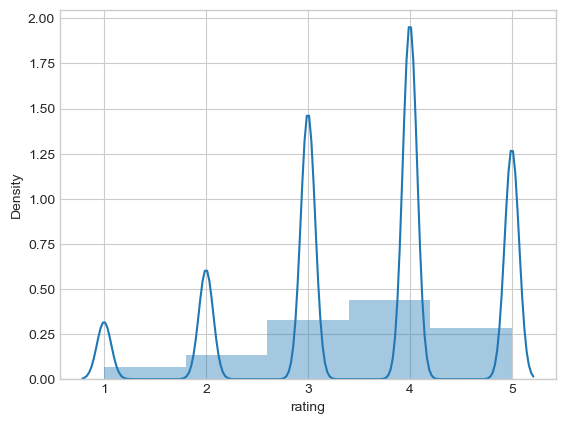

In [6]:
sns.distplot(ratings_df["rating"], bins=5)
plt.show()

## Métriques

In [7]:
def RPP(ranking1, ranking2, p=None):
    if p is None:
        m = min(len(ranking1), len(ranking2))
        p = np.ones(m)/m
    return (p * np.sign(ranking2[:len(p)] - ranking1[:len(p)])).sum()

In [8]:
def DCGPP(ranking1, ranking2):
    m = min(len(ranking1), len(ranking2))
    p = 1 / np.log2(np.arange(1, m+1) + 1)
    p /= p.sum()
    return RPP(ranking1, ranking2, p)

In [9]:
def INVPP(ranking1, ranking2):
    m = min(len(ranking1), len(ranking2))
    p = 1 / np.arange(1, m+1)
    p /= p.sum()
    return RPP(ranking1, ranking2, p)

In [10]:
def ISL(ranking):
    return ranking[0]

def delta_ISL(ranking1, ranking2):
    return ISL(ranking1) - ISL(ranking2)

In [11]:
def TSL(ranking):
    return ranking[-1]

def delta_TSL(ranking1, ranking2):
    return TSL(ranking1) - TSL(ranking2)

In [12]:
def ASL(ranking):
    return np.mean(ranking)

def delta_ASL(ranking1, ranking2):
    return ASL(ranking1) - ASL(ranking2)

In [13]:
def P_at_k(relevant, k):
    return relevant[:min(k, len(relevant))].sum() / k

In [14]:
def AP(ranking):
    return np.mean(1/ranking)

def delta_AP(ranking1, ranking2):
    return AP(ranking1) - AP(ranking2)

In [15]:
def DCG(relevant, k=None):
    if k is None: k=len(relevant)
    return (relevant[:k]/np.log2(np.arange(1, k+1) + 1)).sum()

def delta_DCG(relevant1, relevant2, k=None):
    return DCG(relevant1, k) - DCG(relevant2, k)

In [16]:
def NDCG(relevant, k=None):
    if k is None: k = len(relevant)
    idcg = DCG(np.sort(relevant)[::-1])
    return 0 if idcg == 0 else DCG(relevant)/idcg

def delta_NDCG(relevant1, relevant2, k=None):
    return NDCG(relevant1, k) - NDCG(relevant2, k)

In [17]:
def RR(ranking):
    return 1. / ranking[0]
    
def delta_RR(ranking1, ranking2):
    return RR(ranking1) - RR(ranking2)

In [18]:
def OI(rankings1, rankings2):
    N = min(len(rankings1), len(rankings2))
    p = np.zeros(N)
    clicks_A = 0
    clicks_B = 0
    clicks = 0
    
    for i in range(N):
        if rankings1[i] == rankings2[i]:
            p[i] = 0.5
        elif rankings1[i] < rankings2[i]:
            p[i] = 1
        else:
            p[i] = 0
        
        if np.random.uniform() < p[i]:
            clicks_A += 1
            clicks += 1
        else:
            clicks_B += 1
            clicks += 1
            
    return (clicks_A - clicks_B) / clicks

In [19]:
def RBP(i, gamma):
    return gamma**(i-1)

def DCG2(i):
    return 1 / np.log(i + 1)

In [20]:
def recommander_evaluation(algo, 
                           seuil, 
                           queries, 
                           docs,
                           ratings_df,
                           query_col_name='query_id',
                           doc_col_name='doc_id',
                           rating_col_name='rating'
                          ):
    predictions = dict()
    for query in queries:
        preds_df = pd.DataFrame()
        preds_df[doc_col_name] = docs
        preds_df['score'] = [algo.predict(uid=query, iid=doc).est for doc in docs]
        preds_df = preds_df.sort_values(by='score', ascending=False)
        query_ratings_df = ratings_df[ratings_df[query_col_name] == query][[doc_col_name, rating_col_name]]
        preds_df = preds_df.merge(query_ratings_df, on=doc_col_name, how='left')
        preds_df['rel'] = preds_df[rating_col_name].fillna(0)
        preds_df['rank'] = preds_df['score'].rank(ascending=False).apply(int)
        preds_df['bin'] = preds_df['rel'].apply(lambda x: 1 if x >= seuil else 0)
        predictions[query] = preds_df[[doc_col_name, 'score', 'rel', 'rank', 'bin']]
    return predictions

In [21]:
def compare(predictions1, predictions2, queries):
    rpp_all, dcgpp_all, invpp_all, ndcg_all, dcg_all, ap_all, rr_all, asl_all, oi_all = [], [], [], [], [], [], [], [], []
    
    for query_id in queries:
        rankings1 = np.array(predictions1[query_id][predictions1[query_id]["bin"] == 1]['rank'])
        rankings2 = np.array(predictions2[query_id][predictions2[query_id]["bin"] == 1]['rank'])
        if len(rankings1) == 0:
            rankings1 = np.append(rankings1, len(predictions1[query_id]))
        if len(rankings2) == 0:
            rankings2 = np.append(rankings2, len(predictions2[query_id]))
        
        relevant1 = np.array(predictions1[query_id]['rel'])
        relevant2 = np.array(predictions2[query_id]['rel'])
        
        rpp_all.append( RPP(rankings1, rankings2) )
        dcgpp_all.append( DCGPP(rankings1, rankings2) )
        invpp_all.append( INVPP(rankings1, rankings2) )
        ndcg_all.append( delta_NDCG(relevant1, relevant2) )
        dcg_all.append( delta_DCG(relevant1, relevant2) )
        ap_all.append( delta_AP(rankings1, rankings2) )
        rr_all.append( delta_RR(rankings1, rankings2) )
        asl_all.append(delta_ASL(rankings1, rankings2) )
        oi_all.append(OI(rankings1, rankings2) )
        
    return  rpp_all, dcgpp_all, invpp_all, ndcg_all, dcg_all ,ap_all, rr_all, asl_all, oi_all

In [22]:
def robustess(predictions1,
            predictions2,
            queries,
            docs,
            rpp_all,
            dcgpp_all,
            invpp_all,
            ndcg_all,
            ap_all,
            rr_all,
            doc_col_name='doc_id'):
    
    rpp_tau, dcgpp_tau, invpp_tau, ndcg_tau, ap_tau, rr_tau = [], [], [], [], [], []
    
    for missing_rate in range(90, 0, -10):
        rpp, dcgpp, invpp, ndcg, ap, rr = [], [], [], [], [], []
    
        for query_id in queries:
            preds1_df = predictions1[query_id]
            preds2_df = predictions2[query_id]
        
            n_docs = missing_rate * len(docs) // 100
            missing_docs = np.random.choice(docs, n_docs)
            
            missing_preds1_df = preds1_df.drop(preds1_df[preds1_df[doc_col_name].isin(missing_docs)].index)
            missing_preds1_df["rank"] = missing_preds1_df["score"].rank(ascending=False).apply(int)
            rankings1 = np.array(missing_preds1_df[missing_preds1_df["bin"] == 1]['rank'])
            relevant1 = np.array(missing_preds1_df['rel'])
            
            missing_preds2_df = preds2_df.drop(preds2_df[preds2_df[doc_col_name].isin(missing_docs)].index)
            missing_preds2_df["rank"] = missing_preds2_df["score"].rank(ascending=False).apply(int)
            rankings2 = np.array(missing_preds2_df[missing_preds2_df["bin"] == 1]['rank'])
            relevant2 = np.array(missing_preds2_df['rel'])
            
            if len(rankings1) == 0:
                rankings1 = np.append(rankings1, len(missing_preds1_df))
            if len(rankings2) == 0:
                rankings2 = np.append(rankings2, len(missing_preds2_df))

            rpp.append( RPP(rankings1, rankings2) )
            dcgpp.append( DCGPP(rankings1, rankings2) )
            invpp.append( INVPP(rankings1, rankings2) )
            ndcg.append( delta_NDCG(relevant1, relevant2) )
            ap.append( delta_AP(rankings1, rankings2) )
            rr.append( delta_RR(rankings1, rankings2) )
            
        rpp_tau.append( kendalltau(rpp, rpp_all)[0] )
        dcgpp_tau.append( kendalltau(dcgpp, dcgpp_all)[0] )
        invpp_tau.append( kendalltau(invpp, invpp_all)[0] )
        ndcg_tau.append( kendalltau(ndcg, ndcg_all)[0] )
        ap_tau.append( kendalltau(ap, ap_all)[0] )
        rr_tau.append( kendalltau(rr, rr_all)[0] )
        
    return rpp_tau, dcgpp_tau, invpp_tau, ndcg_tau, ap_tau, rr_tau

In [23]:
def t_test_with_bonferroni_correction(data):
    # Effectue un test T de Student avec correction de Bonferroni
    # sur la liste de données d'entrée
    _, p_val = stats.ttest_ind(data, [0]*len(data))
    p_val *= len(data) # applique la correction de Bonferroni
    return p_val

In [24]:
def power(all_runs, queries, test_fn=t_test_with_bonferroni_correction):
    N = len(all_runs)
    rpp_pvalue, dcgpp_pvalue, invpp_pvalue, ndcg_pvalue, ap_pvalue, rr_pvalue = [], [], [], [], [], []
    for (i, j) in list(itertools.combinations(range(N), 2)):
        rpp_all, dcgpp_all, invpp_all, ndcg_all, _ ,ap_all, rr_all, _, _ = compare(
            all_runs[i], all_runs[j], queries
        )
        rpp_pvalue.append( test_fn(rpp_all) )
        dcgpp_pvalue.append( test_fn(dcgpp_all) )
        invpp_pvalue.append( test_fn(invpp_all) )
        ndcg_pvalue.append( test_fn(ndcg_all) )
        ap_pvalue.append( test_fn(ap_all) )
        rr_pvalue.append( test_fn(rr_all) )
        
    pvalue = .05
    rpp_ratio = np.where(np.array(rpp_pvalue) < pvalue, 1, 0).mean() * 100
    dcgpp_ratio = np.where(np.array(dcgpp_pvalue) < pvalue, 1, 0).mean() * 100
    invpp_ratio = np.where(np.array(invpp_pvalue) < pvalue, 1, 0).mean() * 100
    ndcg_ratio = np.where(np.array(ndcg_pvalue) < pvalue, 1, 0).mean() * 100
    ap_ratio = np.where(np.array(ap_pvalue) < pvalue, 1, 0).mean() * 100
    rr_ratio = np.where(np.array(rr_pvalue) < pvalue, 1, 0).mean() * 100
    
    return rpp_ratio, dcgpp_ratio, invpp_ratio, ndcg_ratio, ap_ratio, rr_ratio

## Expérimentations

In [25]:
reader = Reader(rating_scale=(1.0, 5.0))
data = Dataset.load_from_df(ratings_df[["user_ID", "movie_ID", "rating"]], reader)
trainset, testset = train_test_split(data, test_size=0.2)

In [26]:
movies = ratings_df["movie_ID"].unique()
users = ratings_df['user_ID'].unique()

In [27]:
algo1 = SVD()
algo1.fit(trainset)
predictions1 = recommander_evaluation(
    algo1, 4, users, movies, ratings_df, 'user_ID', 'movie_ID', 'rating'
)

In [28]:
algo2 = BaselineOnly()
algo2.fit(trainset)
predictions2 = recommander_evaluation(
    algo2, 4, users, movies, ratings_df, 'user_ID', 'movie_ID', 'rating'
)

Estimating biases using als...


In [29]:
algo3 = NMF()
algo3.fit(trainset)
predictions3 = recommander_evaluation(
    algo3, 4, users, movies, ratings_df, 'user_ID', 'movie_ID', 'rating'
)

In [30]:
algo4 = CoClustering()
algo4.fit(trainset)
predictions4 = recommander_evaluation(
    algo4, 4, users, movies, ratings_df, 'user_ID', 'movie_ID', 'rating'
)

In [31]:
predictions1[users[0]].head(10)

,movie_ID,score,rel,rank,bin
0,527,4.986759,5.0,1,1
1,1035,4.982576,5.0,2,1
2,2324,4.920282,0.0,3,0
3,953,4.853579,0.0,4,0
4,2905,4.850901,0.0,5,0
5,1207,4.827747,4.0,6,1
6,318,4.814530,0.0,7,0
7,912,4.791008,0.0,8,0
8,668,4.780163,0.0,9,0
9,1148,4.762936,0.0,10,0


### Correlation avec les métriques existantes

In [32]:
rpp_all, dcgpp_all, invpp_all, ndcg_all, dcg_all ,ap_all, rr_all, asl_all, oi_all = compare(
    predictions1, predictions2, users
)

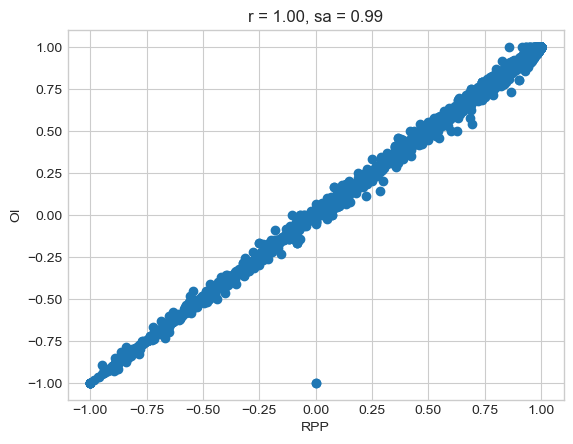

In [33]:
pearson_corr, _ = pearsonr(rpp_all, oi_all)
same_sign_frac = np.sum(np.sign(rpp_all) == np.sign(oi_all)) / len(rpp_all)
plt.scatter(rpp_all, oi_all)
plt.xlabel('RPP')
plt.ylabel('OI')
plt.title('r = {:.2f}, sa = {:.2f}'.format(pearson_corr, same_sign_frac))
plt.show()

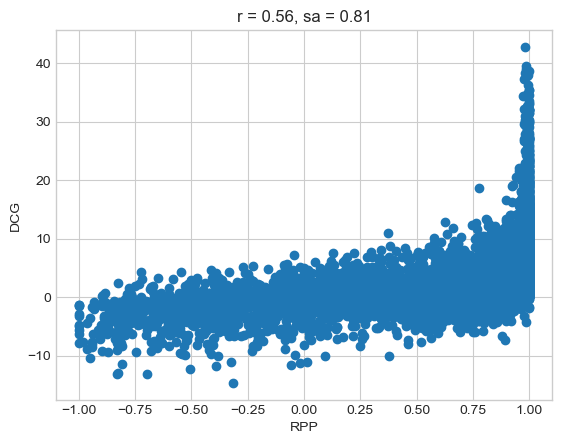

In [34]:
pearson_corr, _ = pearsonr(rpp_all, dcg_all)
same_sign_frac = np.sum(np.sign(rpp_all) == np.sign(dcg_all)) / len(rpp_all)
plt.scatter(rpp_all, dcg_all)
plt.xlabel('RPP')
plt.ylabel('DCG')
plt.title('r = {:.2f}, sa = {:.2f}'.format(pearson_corr, same_sign_frac))
plt.show()

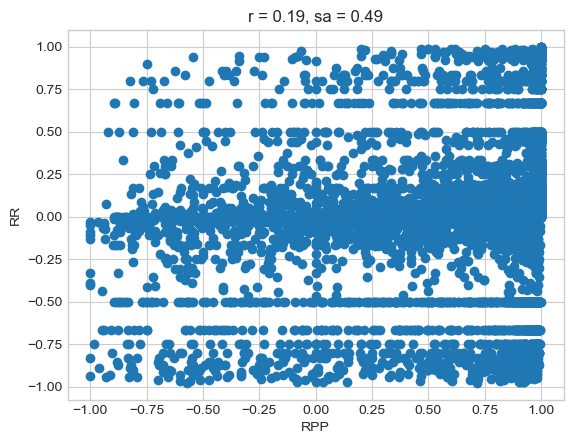

In [35]:
pearson_corr, _ = pearsonr(rpp_all, rr_all)
same_sign_frac = np.sum(np.sign(rpp_all) == np.sign(rr_all)) / len(rpp_all)
plt.scatter(rpp_all, rr_all)
plt.xlabel('RPP')
plt.ylabel('RR')
plt.title('r = {:.2f}, sa = {:.2f}'.format(pearson_corr, same_sign_frac))
plt.show()

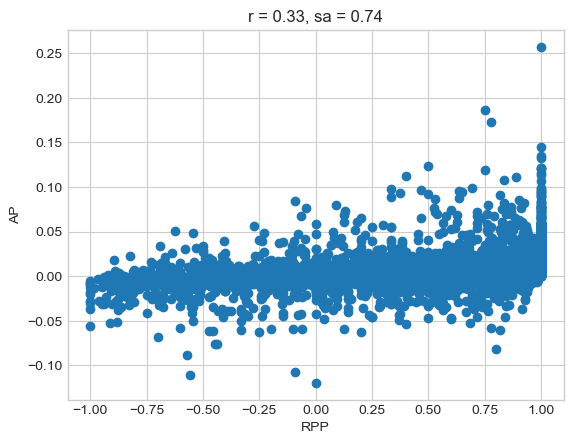

In [36]:
pearson_corr, _ = pearsonr(rpp_all, ap_all)
same_sign_frac = np.sum(np.sign(rpp_all) == np.sign(ap_all)) / len(rpp_all)
plt.scatter(rpp_all, ap_all)
plt.xlabel('RPP')
plt.ylabel('AP')
plt.title('r = {:.2f}, sa = {:.2f}'.format(pearson_corr, same_sign_frac))
plt.show()

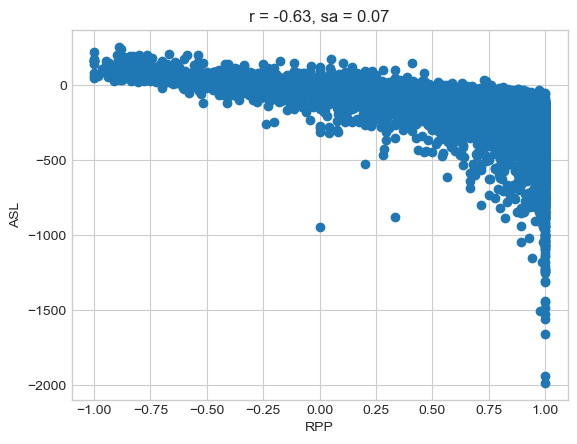

In [37]:
pearson_corr, _ = pearsonr(rpp_all, asl_all)
same_sign_frac = np.sum(np.sign(rpp_all) == np.sign(asl_all)) / len(rpp_all)
plt.scatter(rpp_all, asl_all)
plt.xlabel('RPP')
plt.ylabel('ASL')
plt.title('r = {:.2f}, sa = {:.2f}'.format(pearson_corr, same_sign_frac))
plt.show()

### Robustesse aux données incomplètes

In [38]:
rpp_tau, dcgpp_tau, invpp_tau, ndcg_tau, ap_tau, rr_tau = robustess(
    predictions1, predictions2, users, movies,
    rpp_all, dcgpp_all, invpp_all, ndcg_all, ap_all, rr_all, 'movie_ID'
)

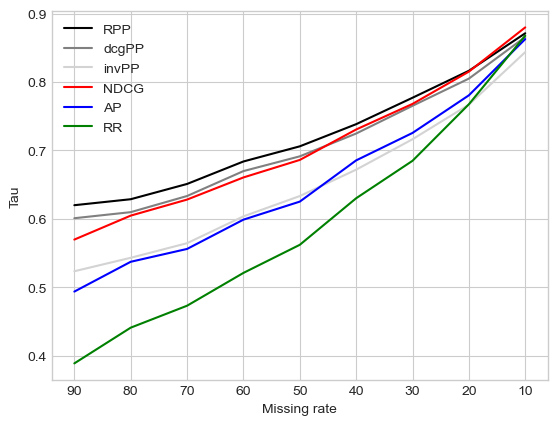

In [39]:
missing_rate = np.arange(90, 0, -10)
plt.plot(missing_rate, rpp_tau, label='RPP', c='black')
plt.plot(missing_rate, dcgpp_tau, label='dcgPP', c='gray')
plt.plot(missing_rate, invpp_tau, label='invPP', c='lightgray')
plt.plot(missing_rate, ndcg_tau, label='NDCG', c='red')
plt.plot(missing_rate, ap_tau, label='AP', c='blue')
plt.plot(missing_rate, rr_tau, label='RR', c='green')
plt.xlabel('Missing rate')
plt.ylabel('Tau')
plt.gca().invert_xaxis()
plt.legend()
plt.show()

### Pouvoir discriminant

In [40]:
queries = ratings_df['user_ID'].unique()
queries.sort()

In [41]:
all_movies_run = [predictions1, predictions2, predictions3, predictions4]
rpp_ratio, dcgpp_ratio, invpp_ratio, ndcg_ratio, ap_ratio, rr_ratio = power(all_movies_run, queries)
rpp_ratio, dcgpp_ratio, invpp_ratio, ndcg_ratio, ap_ratio, rr_ratio

(100.0, 100.0, 100.0, 100.0, 83.33333333333334, 83.33333333333334)

In [42]:
def load_movies_data(filename, ratings_df, seuil, queries):
    df = pd.read_csv(filename, sep='\t', header=None, names=['query_id', 'dummy', 'doc_id', 'rank', 'score', 'method'])
    dfs = []
    for qid in queries:
        qid_df = df[df['query_id'] == qid][['query_id', 'doc_id', 'rank']]
        query_ratings_df = ratings_df[ratings_df['user_ID'] == qid][['movie_ID', 'rating']].rename(columns={'movie_ID': 'doc_id'})
        qid_df = qid_df.merge(query_ratings_df, on='doc_id', how='left')
        qid_df['rank'] = qid_df['rank'] + 1
        qid_df['rel'] = qid_df['rating'].fillna(0)
        qid_df['bin'] = qid_df['rel'].apply(lambda x: 1 if x >= seuil else 0)
        qid_df = qid_df.drop(columns=['rating'])
        dfs.append(qid_df) 
    return dfs

In [43]:
all_movies_run2 = [
    load_movies_data(f"../data/runs-ml-1M/{filename}", ratings_df, 4, queries)
    for filename in os.listdir("../data/runs-ml-1M/")
]

In [44]:
rpp_ratio, dcgpp_ratio, invpp_ratio, ndcg_ratio, ap_ratio, rr_ratio = power(all_movies_run2, queries-1)
rpp_ratio, dcgpp_ratio, invpp_ratio, ndcg_ratio, ap_ratio, rr_ratio

(94.28571428571428,
 93.80952380952381,
 92.38095238095238,
 90.47619047619048,
 83.80952380952381,
 84.76190476190476)